+ 6.1: Inference on videos
+ 6.2: MBARI side-by-side comparison

In [1]:
from net import WaterNet
from data import transform
import cv2
from pathlib import Path
import torch
import numpy as np
from einops import rearrange
import pickle
import random

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Util fxns

In [3]:
def arr2ten(arr):
    """Convert arr2ten plus scaling"""
    ten = torch.from_numpy(arr) / 255
    ten = rearrange(ten, "h w c -> 1 c h w")
    return ten

def ten2arr(ten):
    """Convert ten2arr plus scaling"""
    arr = ten.cpu().detach().numpy()
    arr = np.clip(arr, 0, 1)
    arr = (arr * 255).astype(np.uint8)
    arr = rearrange(arr, "c h w -> h w c")
    return arr

## Load weights

In [4]:
waternet = WaterNet()

with open("../waternet_exported_state_dict-daa0ee.pt", "rb") as f:
    exported_sd = torch.load(f)

waternet.load_state_dict(exported_sd)

<All keys matched successfully>

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [6]:
waternet = waternet.to(device)
waternet.eval();

## Video in / out setup

In [7]:
srcvid = "../data/internet/StationMBackground.mp4"

In [8]:
outpath = "../output/mbari-side-by-side.mp4"

cap = cv2.VideoCapture(srcvid)

frames_per_second = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

codec = cv2.VideoWriter.fourcc(*"avc1")
video_writer = cv2.VideoWriter(
    outpath, codec, frames_per_second, (frame_width, frame_height)
)

In [9]:
frame_width, frame_height

(1920, 1080)

In [10]:
composite_im = np.zeros(shape=(1080, 1920))

In [11]:
cv2.putText(
    img=composite_im,
    text=f"Before",
    # location of bottom-left corner of text
    org=(720, 200), # W, H
    # just pick sth not ugly
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=2,  # multiplied by font base size
    color=(255, 255, 255),
    thickness=3,
);

In [12]:
cv2.putText(
    img=composite_im,
    text=f"After",
    # location of bottom-left corner of text
    org=(1000, 200),
    # just pick sth not ugly
    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    fontScale=2,  # multiplied by font base size
    color=(255, 255, 255),
    thickness=3,
);

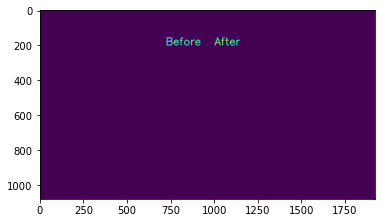

In [13]:
plt.imshow(composite_im)

In [14]:
1920 / 2

960.0

In [15]:
frames = 0

while True:
    retval, image = cap.read()

    if retval is False:
        break

    # Logic start ------------------------------------
    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    wb, gc, he = transform(rgb)

    rgb_ten = arr2ten(rgb)
    wb_ten =  arr2ten(wb)
    gc_ten =  arr2ten(gc)
    he_ten =  arr2ten(he)

    with torch.no_grad():
        rgb_ten = rgb_ten.to(device)
        wb_ten = wb_ten.to(device)
        gc_ten = gc_ten.to(device)
        he_ten = he_ten.to(device)

        out = waternet(rgb_ten, wb_ten, he_ten, gc_ten)
        out_im = ten2arr(out[0])
        
    w = 960
    composite_im = np.zeros_like(rgb)
    composite_im[:, :w, :] = rgb[:, :w, :]
    composite_im[:, w:, :] = out_im[:, w:, :]

    cv2.putText(
        img=composite_im,
        text=f"Before",
        # location of bottom-left corner of text
        org=(720, 200), # W, H
        # just pick sth not ugly
        fontFace=cv2.FONT_HERSHEY_DUPLEX,
        fontScale=2,  # multiplied by font base size
        color=(255, 255, 255),
        thickness=3,
    );

    cv2.putText(
        img=composite_im,
        text=f"After",
        # location of bottom-left corner of text
        org=(1000, 200),
        # just pick sth not ugly
        fontFace=cv2.FONT_HERSHEY_DUMPLEX,
        fontScale=2,  # multiplied by font base size
        color=(255, 255, 255),
        thickness=3,
    );
    
    video_writer.write(composite_im)
    frames += 1

    if frames % 50 == 0:
        print(f"Processed {frames} frames")

cap.release()
video_writer.release()

cv2.destroyAllWindows()

Processed 50 frames
Processed 100 frames
Processed 150 frames
Processed 200 frames
Processed 250 frames
Processed 300 frames
Processed 350 frames


In [16]:
print("Done!")

Done!


Seems to take more than one second for each frame.